<a href="https://colab.research.google.com/github/tamucc-gcl/wrkshp_edna_metabarcoding/blob/main/analysis/data_cleanup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post-Bioionformatic Data Processing

This notebook will:



---
## Initialize Environment

In [ ]:
#Set-up Computing Environment - Python

## Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.environ['COLAB'] = 'TRUE'

## Install Linux programs needed
!apt install libfribidi-dev libglpk-dev libharfbuzz-dev pandoc

## Clone GitHub Repo and move into that repo
local_path = '/content/edna_workshop'
repo  = "tamucc-gcl/wrkshp_edna_metabarcoding"
url = f"https://github.com/{repo}.git"
!git clone {url} {local_path}

## Setup R and move to local directory
os.chdir(local_path)
%reload_ext rpy2.ipython

In [ ]:
#Set-up Computing Environment - R
%%R -i local_path
# Point R at your Drive-backed library
drive_lib <- "/content/drive/MyDrive/edna_libraries"
dir.create(drive_lib, recursive = TRUE, showWarnings = FALSE)
.libPaths(c(drive_lib, .libPaths()))

#Install renv if it isn't already
if (!require("renv", lib.loc = drive_lib, quietly = TRUE, warn.conflicts = FALSE)) {
  install.packages("renv", lib = drive_lib,
                   quietly = TRUE, warn.conflicts = FALSE)
}

#Install required libraries into google drive if they aren't already
renv::restore(library = drive_lib,
              lockfile = paste0(local_path, '/renv.lock'),
              prompt = FALSE)

---
## Parameter Setting

In [3]:
%%R
min_read_count <- 1000 #Minimum number of reads in a sample to keep it

---
## Libraries

In [4]:
%%R
library(janitor)
library(tidyverse)
library(rfishbase)
library(bold)
library(taxize)
library(ggtext)
library(ggrepel)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::modify() masks renv::modify()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘janitor’

The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Attaching package: ‘taxize’

The following object is masked from ‘package:rfishbase’:

    synonyms



---
## Read in Data

In [6]:
%%R
samples_with_barcodes <- read_tsv(str_c(here::here(),
               'data/rb_input_barcode.txt',
               sep = '/'),
               show_col_types = FALSE) %>%
  select(sample) %>%
  separate_wider_delim(cols = sample,
                       names = c("pool", "sample_id"),
                       delim = "_")

sampling_metadata <- read_tsv(str_c(here::here(),
                                    'data/Simons_MasterSheet_2017-11-10_2.tsv',
                                   sep = '/'),
                             show_col_types = FALSE, na = c('NA', '?', '')) %>%
  clean_names() %>%
  mutate(sample_id = str_replace_all(vial_label, '-', ''),
         .keep = 'unused') %>%
  inner_join(samples_with_barcodes,
             by = 'sample_id') %>%
  mutate(predator_species_name = if_else(predator_species_name == 'Ophidion welshi',
                                         "Ophidion josephi", predator_species_name))


#there are two samples with sequencing (in abundance matrix/samples_with_barcodes) without any info in the metadata: 1949E & 1751A

abundance_matrix <- read_csv(str_c(here::here(),
                                   'output/rainbow_bridge/zotu_table.csv',
                                   sep = '/'),
                             show_col_types = FALSE)

zotu_sequences <- Biostrings::readDNAStringSet(str_c(here::here(),
                                   'output/rainbow_bridge/zotu_sequences.fasta',
                                   sep = '/'))

zotu_taxonomy <- abundance_matrix %>%
  select(zotu, domain:species, taxid_rank) %>%
  distinct()


New names:
• `Primer.Plate` -> `Primer.Plate...18`
• `Band` -> `Band...22`
• `Primer.Dimer` -> `Primer.Dimer...23`
• `Smear` -> `Smear...24`
• `Non.Specific.Product` -> `Non.Specific.Product...25`
• `Primer.Plate` -> `Primer.Plate...28`
• `Band` -> `Band...30`
• `Primer.Dimer` -> `Primer.Dimer...31`
• `Smear` -> `Smear...32`
• `Non.Specific.Product` -> `Non.Specific.Product...33`


---
## Join Data

In [7]:
%%R
joined_zotu_data <- abundance_matrix %>%
  select(zotu, species, starts_with("Simons")) %>%
  pivot_longer(cols = starts_with("Simons"),
               names_to = c('pool', 'sample_id'),
               names_pattern = '(.*)_(.*)',
               values_to = 'n_reads') %>%
  inner_join(select(sampling_metadata,
                    pool, sample_id,
                    predator_species_name),
             by = c('pool', 'sample_id')) %>%
  filter(n_reads > 0)

---
## Data Summary

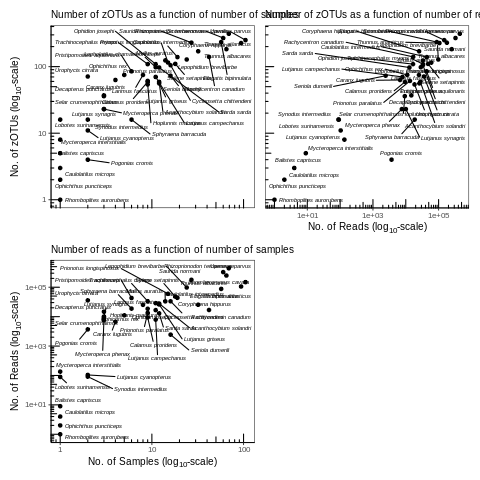

In [8]:
%%R
font_size <- 2
plot_nzotu_nsamples <- joined_zotu_data %>%
  summarise(n_samples = n_distinct(sample_id),
            n_zotus = n_distinct(zotu),
            n_reads = sum(n_reads),
            .by = c(predator_species_name)) %>%
  ggplot(aes(x = n_samples,
             y= n_zotus)) +
  geom_point() +
  geom_text_repel(aes(label = predator_species_name),
                  size = font_size,
                  max.overlaps = 30,
                  fontface="italic") +
  scale_x_continuous(transform = scales::log10_trans()) +
  scale_y_continuous(transform = scales::log10_trans()) +
  annotation_logticks() +
  labs(x = "No. of Samples (log<sub>10</sub>-scale)",
       y = "No. of zOTUs (log<sub>10</sub>-scale)",
       subtitle = "Number of zOTUs as a function of number of samples") +
  theme_classic(base_size = 10) +
  theme(axis.title = element_markdown(),
        panel.background = element_rect(colour = 'black'))

plot_nreads_nsamples <- joined_zotu_data %>%
  summarise(n_samples = n_distinct(sample_id),
            n_zotus = n_distinct(zotu),
            n_reads = sum(n_reads),
            .by = c(predator_species_name)) %>%
  ggplot(aes(x = n_samples,
             y= n_reads)) +
  geom_point() +
  geom_text_repel(aes(label = predator_species_name),
                  size = font_size,
                  max.overlaps = 30,
                  fontface="italic") +
  scale_x_continuous(transform = scales::log10_trans()) +
  scale_y_continuous(transform = scales::log10_trans()) +
  annotation_logticks() +
  labs(x = "No. of Samples (log<sub>10</sub>-scale)",
       y = "No. of Reads (log<sub>10</sub>-scale)",
       subtitle = "Number of reads as a function of number of samples") +
  theme_classic(base_size = 10) +
  theme(axis.title = element_markdown(),
        panel.background = element_rect(colour = 'black'))

plot_nzotus_nreads <- joined_zotu_data %>%
  summarise(n_samples = n_distinct(sample_id),
            n_zotus = n_distinct(zotu),
            n_reads = sum(n_reads),
            .by = c(predator_species_name)) %>%
  ggplot(aes(x = n_reads,
             y= n_zotus)) +
  geom_point() +
  geom_text_repel(aes(label = predator_species_name),
                  size = font_size,
                  max.overlaps = 30,
                  fontface="italic") +
  scale_x_continuous(transform = scales::log10_trans()) +
  scale_y_continuous(transform = scales::log10_trans()) +
  annotation_logticks() +
  labs(x = "No. of Reads (log<sub>10</sub>-scale)",
       y = "No. of zOTUs (log<sub>10</sub>-scale)",
       subtitle = "Number of zOTUs as a function of number of reads") +
  theme_classic(base_size = 10) +
  theme(axis.title = element_markdown(),
        panel.background = element_rect(colour = 'black'))

plot_nzotu_nsamples + plot_nzotus_nreads + plot_nreads_nsamples + plot_spacer() +
  plot_layout(nrow = 2, guides = 'collect', axes = 'collect')

---
## Data Cleaning
Remove samples/zotus which don't meet prespecified criteria:


1.   zOTU sequence must be 313 bp length
2.   Remove zOTUs identified as the predator species
3. Remove Predator species with less than 1,000 reads across all samples/zOTUs

In [9]:
%%R
msgs <- c()

filter_predators <- function(data, min_reads){
  out <- data %>%
    filter(sum(n_reads) >= min_read_count,
           .by = c(predator_species_name))

  removed_preds <- anti_join(data, out,
                             by = colnames(data)) %>%
    pull(predator_species_name) %>% n_distinct()

  msgs <<- c(msgs, paste0('\n', 'Number of predator species with fewer than ',
          scales::comma(min_reads), ' total reads: ', scales::comma(removed_preds)))
  msgs <<- c(msgs, paste0('Predator species remaining: ', scales::comma(n_distinct(out$predator_species_name)), '\n'))
  out
}

filter_self <- function(data){
  out <- data %>%
    filter(species != predator_species_name)

  removed_zotus <- anti_join(data, out,
                             by = colnames(data)) %>%
    pull(zotu) %>% n_distinct()

  msgs <<- c(msgs, paste0('\n', 'Number of zOTUs matching predator species: ', scales::comma(removed_zotus)))
  msgs <<- c(msgs, paste0('zOTUs remaining: ', scales::comma(n_distinct(out$zotu)), '\n'))

  out
}

# Identify zotus with a non-standard length sequence
zotus_to_keep <- names(zotu_sequences)[Biostrings::width(zotu_sequences) == 313] %>%
  str_extract('Zotu[0-9]+')

msgs <- c(msgs, paste0('\n', 'Number of zOTUs not 313 bp long: ',
                       scales::comma(length(zotu_sequences) - length(zotus_to_keep))))
msgs <- c(msgs, paste0('zOTUs remaining: ', scales::comma(length(zotus_to_keep)), '\n'))

# Main processing
predator_gut_contents <- joined_zotu_data %>%
  filter(zotu %in% zotus_to_keep) %>%
  filter_self() %>%
  select(-species) %>%
  filter_predators(min_read_count)

# Finally, print all collected messages
cat(paste(msgs, collapse = "\n"))


Number of zOTUs not 313 bp long: 76
zOTUs remaining: 460


Number of zOTUs matching predator species: 27
zOTUs remaining: 459


Number of predator species with fewer than 1,000 total reads: 11
Predator species remaining: 34


---
## Post Cleaning Data Summary

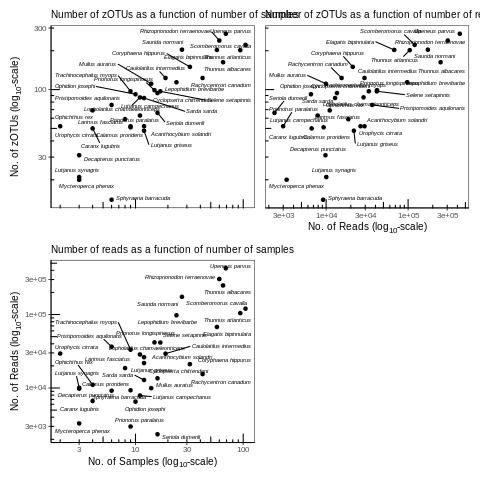

In [10]:
%%R
font_size <- 2
plot_nzotu_nsamples <- predator_gut_contents %>%
  summarise(n_samples = n_distinct(sample_id),
            n_zotus = n_distinct(zotu),
            n_reads = sum(n_reads),
            .by = c(predator_species_name)) %>%
  ggplot(aes(x = n_samples,
             y= n_zotus)) +
  geom_point() +
  geom_text_repel(aes(label = predator_species_name),
                  size = font_size,
                  max.overlaps = 30,
                  fontface="italic") +
  scale_x_continuous(transform = scales::log10_trans()) +
  scale_y_continuous(transform = scales::log10_trans()) +
  annotation_logticks() +
  labs(x = "No. of Samples (log<sub>10</sub>-scale)",
       y = "No. of zOTUs (log<sub>10</sub>-scale)",
       subtitle = "Number of zOTUs as a function of number of samples") +
  theme_classic(base_size = 10) +
  theme(axis.title = element_markdown(),
        panel.background = element_rect(colour = 'black'))

plot_nreads_nsamples <- predator_gut_contents %>%
  summarise(n_samples = n_distinct(sample_id),
            n_zotus = n_distinct(zotu),
            n_reads = sum(n_reads),
            .by = c(predator_species_name)) %>%
  ggplot(aes(x = n_samples,
             y= n_reads)) +
  geom_point() +
  geom_text_repel(aes(label = predator_species_name),
                  size = font_size,
                  max.overlaps = 30,
                  fontface="italic") +
  scale_x_continuous(transform = scales::log10_trans()) +
  scale_y_continuous(transform = scales::log10_trans()) +
  annotation_logticks() +
  labs(x = "No. of Samples (log<sub>10</sub>-scale)",
       y = "No. of Reads (log<sub>10</sub>-scale)",
       subtitle = "Number of reads as a function of number of samples") +
  theme_classic(base_size = 10) +
  theme(axis.title = element_markdown(),
        panel.background = element_rect(colour = 'black'))

plot_nzotus_nreads <- predator_gut_contents %>%
  summarise(n_samples = n_distinct(sample_id),
            n_zotus = n_distinct(zotu),
            n_reads = sum(n_reads),
            .by = c(predator_species_name)) %>%
  ggplot(aes(x = n_reads,
             y= n_zotus)) +
  geom_point() +
  geom_text_repel(aes(label = predator_species_name),
                  size = font_size,
                  max.overlaps = 30,
                  fontface="italic") +
  scale_x_continuous(transform = scales::log10_trans()) +
  scale_y_continuous(transform = scales::log10_trans()) +
  annotation_logticks() +
  labs(x = "No. of Reads (log<sub>10</sub>-scale)",
       y = "No. of zOTUs (log<sub>10</sub>-scale)",
       subtitle = "Number of zOTUs as a function of number of reads") +
  theme_classic(base_size = 10) +
  theme(axis.title = element_markdown(),
        panel.background = element_rect(colour = 'black'))

plot_nzotu_nsamples + plot_nzotus_nreads + plot_nreads_nsamples + plot_spacer() +
  plot_layout(nrow = 2, guides = 'collect', axes = 'collect')

---
## Get Predator Information

In [20]:
%%R
get_fishbase_data <- function(species_df, species_col = 'species',
                              datasets = c('species', 'ecology', 'estimate',
                                           'morphology', 'reproduction', 'morphometrics')){
  #Datasets: the rfishbase functions (quoted) to get information from

  out <- species_df
  for(func_name in datasets){

    func <- get(func_name, envir = asNamespace("rfishbase"))
    search_result <- func(pull(species_df, species_col)) %>%
      janitor::remove_empty(which = 'cols')

    join_vec <- join_by(!!sym(species_col) == 'Species',
                        !!!syms(intersect(colnames(out),
                                          colnames(search_result))))

    out <- out %>%
      left_join(search_result,
                by = join_vec) %>%
      nest(!!sym(str_c('fishbase_search_', func_name)) := str_subset(colnames(search_result), '^Species$', negate = TRUE))
  }

  out
}

if(!file.exists(str_c(here::here(),
                      'intermediate_files/predator_taxonomy.rds',
                      sep = '/'))){
  fishbase_db <- load_taxa() %>%
    clean_names()

  predator_taxonomy <- sampling_metadata %>%
    mutate(predator_species_name = case_when(predator_species_name == "Ophidion welshi" ~ "Ophidion josephi",
                                             TRUE ~ predator_species_name)) %>%
    distinct(predator_species_name) %>%
    pull(predator_species_name) %>%
    tax_name(get = c("kingdom", "phylum", "class", "order", "family", "genus", "species"),
             db = "ncbi") %>%
    as_tibble() %>%
    left_join(fishbase_db %>% select(species, order_fishbase = order), by = "species") %>%
    mutate(order = coalesce(order, order_fishbase),
           .keep = 'unused') %>%
    select(-db, -query) %>%
    get_fishbase_data()
}

if(nzchar(Sys.getenv("COLAB"))){
    predator_taxonomy <- read_rds(str_c(here::here(),
                                        'intermediate_files/predator_taxonomy.rds',
                                        sep = '/'))
}

---
## Write Cleaned files for future use

In [25]:
%%R
storage_dir <- if_else(nzchar(Sys.getenv("COLAB")), drive_lib, here::here())
dir.create(str_c(storage_dir, 'intermediate_files', sep = '/'), showWarnings = FALSE)

predator_gut_contents %>%
  pivot_wider(names_from = 'zotu',
              values_from = n_reads,
              values_fill = 0L) %>%
  write_csv(str_c(storage_dir,
                  'intermediate_files/filtered_zotu_counts.csv',
                  sep = '/'))

write_csv(zotu_taxonomy,
          str_c(storage_dir,
                  'intermediate_files/zotu_taxonomy.csv',
                  sep = '/'))

write_rds(predator_taxonomy,
          str_c(storage_dir,
                'intermediate_files/predator_taxonomy.rds',
                sep = '/'))

In [ ]:
#Cleanly unmount Google Drive
drive.flush_and_unmount()